In [3]:
# Basic imports
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import os
import json
import sys
# Import custom functions from scripts directory.
sys.path.append('scripts')
import color_functions as color
import warp_functions as warp

## Load an image: 
You need an image to be loaded in the kernel as a 3D-numpy-array. You should put your image the project's folder under the subfolders: data/raw_data. The image name is stored as a setting which you can alter in the settings.json file. This settings file is in the root directory of the project

In [4]:
#read the image name from the settings.json file.
with open('settings.json', 'r') as settings_file:
    settings = json.load(settings_file)
loc_input_img = os.path.join('data', 'raw_data', settings['image_name'])
# open the image using PIL, then make a numpy array from it.
# do not directly modify the np_image variable. Otherwise you
# might carry over unwanted edits to other renders.
image = Image.open(loc_input_img)
np_image = np.array(image)

In [5]:
def process_command(commands):
    """
        Function which takes the commands for a single cell (list), starts
        with copying the original image and passes it to all appropriate
        functions depending on the given list of commands. 
        It returns the modified image.
    """
    #numpy reshape converts the size_boost value to str, convert it back here.
    size_boost = int(commands[0])
    color_command = commands[1]
    warp_command = commands[2]
    #copy prevents carrying over changes to other cells.
    image = np_image.copy()
    if size_boost > 1:
       image = warp.resize(image, size_boost)        
    if color_command:
        image = color.command_interpreter(image, color_command)
    if warp_command:
        image = warp.command_interpreter(image, warp_command)
    return image


shape_width = np_image.shape[0]
shape_height = np_image.shape[1]
def convert_recipe_to_image_matrix(recipe):
    """
        Function takes the recipe you give it and produces an image based on 
        the individual cell commands.
        NOTE: this function will only work for recipes where the numpy array
        to generate is the same size OR where the size is the product of the 
        given rows and cols.
    """
    grid_width = recipe['cols']
    grid_height = recipe['rows']
    cells = recipe['cells']
    if len(cells) != grid_height*grid_width:
        raise Exception(
            f"Invalid recipe: {len(cells)} cells given for a grid where {grid_height*grid_width} cells are expected."
        )
    #use dtype int!! otherwise the image is cyan (mixing float and int throws off plt)
    grid = np.ones((grid_height*shape_width, grid_width*shape_height, 3), dtype=int)
    for i in range(len(cells)):
        cell = cells[i]
        cell_image = process_command(cell)
        row_start = (i // grid_width) * shape_width
        col_start = (i % grid_width) * shape_height
        #If grow_factor is 0 ==> i.e.: the cell has to be hidden but row_start and col_start need to shift.
        try:
            if cell[0] != 0:
                # Add cell_image to the corresponding position in the grid
                grid[row_start:row_start + cell_image.shape[0], col_start:col_start + cell_image.shape[1], :] = cell_image
        except:
            raise Exception(
                f""
            )
    return grid

## Making an image recipe: 

If your output image result in the exact same shape, or an exact multitude of the original shape, you can use simple image recipes to generate your image. 
For a detailed breakdown of image recipes, see the included readme.md file. The following cells will show you 4 different recipes and four different outputs.

<function matplotlib.pyplot.show(close=None, block=None)>

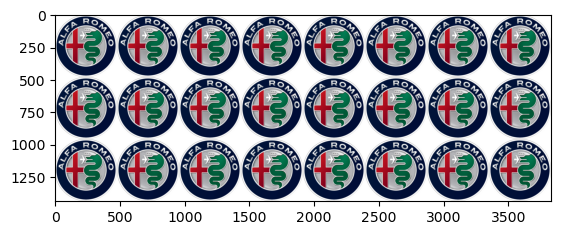

In [6]:
#Make your image recipes: an image recipe is a dict 
#>KEY = type: description
# rows = (int): How many rows in the final grid
# cols = (int): How many colums in the final grid
# cells = list(a) of lists. 
#   len(a) should be equal to rows*cols
#   The order of the cells in a matters: the first cell is the topleft corner
#   every other cell gets added to the right of that. When the end of a
#   row is reached, the next cell gets added on the far left again.
#   in a 3*3 grid this becomes: [1,2,3,4,5,6,7,8,9]
#                                   1  2  3
#                                   4  5  6
#                                   7  8  9
#   every sublist contains three elements. The order matters:
#       0: INT grow factor 
#       1: False or str: Color modifications
#       2: False or str: Warp modifications
#   for the correct commands, see the readme.md file.

#Instructions for Image ONE
#you just repeat the same image ove ran over. So 24 copies of the same cell
recipe_image_one = {
    'cols': 8,
    'rows': 3,
    'cells': 24*[[1, False, False] ]
}

#image 1: baking the recipe: simple 8*3 grid same image gets repeated all the time
plt.imshow(convert_recipe_to_image_matrix(recipe_image_one))
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

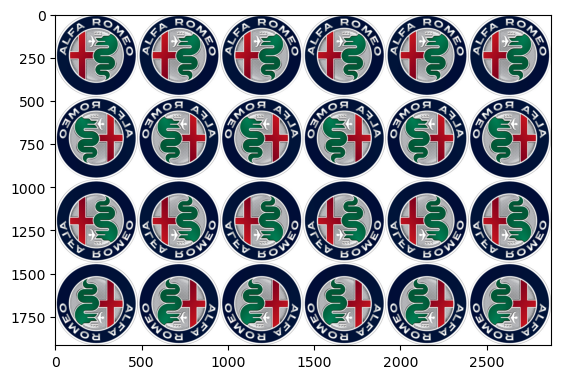

In [7]:
#instructions for Image TWO
cellcommands_image_two = []
#first row: no modifications at all
cellcommands_image_two.extend(6*[[1, False, False]])           
#second row: no size increase, no color mod and  mirror over the Y axis
cellcommands_image_two.extend(6*[[1, False, 'mirror_y']])
#third row: no size increase, no color mod and mirror over the X axis
cellcommands_image_two.extend(6*[[1, False, 'mirror_x']])      
#fourth row: no size increase, no color mod and rotate 180° over the cell center
cellcommands_image_two.extend(6*[[1, False, 'rot_180']])       
recipe_image_two = {
    'cols': 6,
    'rows': 4,
    'cells': cellcommands_image_two
}

#image 2: baking the recipe: 6*4 grid image flips and mirrors per row.
plt.imshow(convert_recipe_to_image_matrix(recipe_image_two))
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

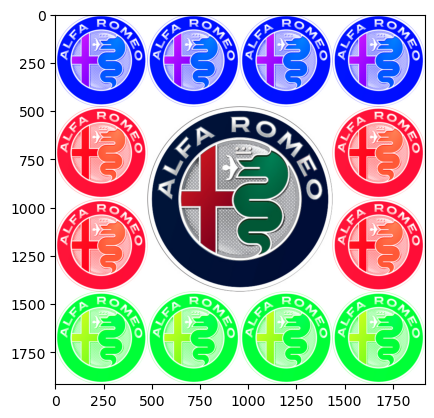

In [8]:
#instructions for Image THREE (Example where a grow factor is used. )
cellcommands_image_three = []
#Boost the blue channel using B
cellcommands_image_three.extend(4*[[1, 'B', False]])
#Boost the red channel using R
cellcommands_image_three.append([1, 'R', False])
#stretch the image factor 2
cellcommands_image_three.append([2, False, False])
#skip cell (indicated by 0 for grow factor)
cellcommands_image_three.append([0, False, False])
#Boost the red channel using R
cellcommands_image_three.extend(2*[[1, 'R', False]])
#skip two more cells to compensate for grow factor 2*2
cellcommands_image_three.extend(2*[[0, False, False]])
#Boost the red channel using R
cellcommands_image_three.append([1, 'R', False])
#Boost the green channel using G
cellcommands_image_three.extend(4*[[1, 'G', False]])
recipe_image_three = {
    'cols': 4,
    'rows': 4,
    'cells': cellcommands_image_three
}

# image 2: baking the recipe: 4*4 grid image with center image twice as big as 
# the surrounding cells. Surrounding image have changes made to the color channel. 

plt.imshow(convert_recipe_to_image_matrix(recipe_image_three))
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

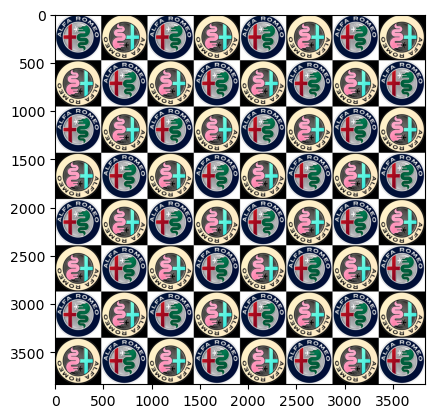

In [9]:
##      EXTRA IMAGE GENERATOR ONE: 

# first extra image will reuse the recipe-interpreter
# the goal is to create a checkered flag of n*m dimensions
# The newly used function for this is in color_functions.py
# and generates a negative. For the demonstration let's make a 
# board of chess: 
def checkered_recipe_maker(horizontal_repeat:int, vertical_repeat:int, top_left:bool= False): 
    # start with optimizing the matrix so that horizonal_repeat*matrix_width == max_width(less pixels to work with)
    # Create a 3D array with alternating True and False values based on the checkered pattern
    # use a 3D array to allow uneven grids
    check_pattern = np.zeros((horizontal_repeat, vertical_repeat, 3), dtype=object)
    #top_left is either 1, false, false OR 1, 'N', 'rot_180
    if top_left:
        first_box = np.array([1, False, False])
        second_box = np.array([1, 'N', 'rot_180'])
    else: 
        first_box = np.array([1, 'N', 'rot_180'])
        second_box = np.array([1, False, False])

    # Use NumPy array slicing to set alternate values in the check_pattern array
    #make the grid pattern by changinc collor to Negative
    check_pattern[::2, ::2] = first_box
    check_pattern[1::2, 1::2] = first_box
    check_pattern[::2, 1::2] = second_box
    check_pattern[1::2, ::2] = second_box
    return check_pattern.reshape((horizontal_repeat*vertical_repeat, 3))


recipe_image_extra_one = {
    'rows': 8,
    'cols': 8,
    'cells': checkered_recipe_maker(8, 8, True)
}

plt.imshow(convert_recipe_to_image_matrix(recipe_image_extra_one))
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

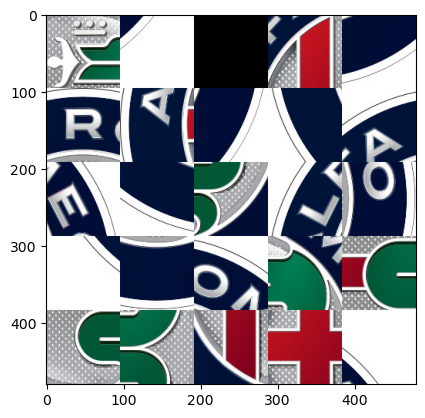

In [10]:
##      EXTRA IMAGE GENERATOR TWO: 
# the output grid can have a slightly different shape than the original
# np_image, so you have to call this directly without using the 
# convenience 'command_interpreter(<command>)' function

plt.imshow(warp.sliding_puzzle_image_generator(np_image, 5, 5))
plt.show